# Hate Speech Detection


Steps:
* **Enviorment Setup** - Autogloun in Google colob needs extra configs, BERT
* **Data Cleaning** - Removal of Greek words, @,numbers, slang words, stop words. Performed Lemmatization, Stemming techniques.
* **Bag of Words Technique** - Converted tweets into TF-IDF feature matrix to apply machine learning models on top of it.
* **Word Embedding Technique** - Used Word2vec genism approch to train vectors and apply RandomForestClassifier to mesaure performance.
* **Autogluon approach** - Adopting the best model using Autogluon
* **Language Modelling using BERT** 


In [ ]:
#For Autogluon
# Uninstall mkl for faster neural-network training time
!pip uninstall -y mkl
# Upgrade pip to ensure the latest package versions are available
!pip install -U pip
!pip install -U "mxnet<2.0.0"
!pip install autogluon
!pip install -U ipykernel

In [ ]:
# pip freeze to show the exact versions used in the original tutorial
!pip freeze
#Retstart your notebook after this step 

In [ ]:
# Installation for tensorfloe, torch, transformers,  genism

!pip install --upgrade torch
!pip install --upgrade tensorflow
!pip install gensim
!pip install transformers

In [ ]:
!pip install unidecode
!pip install wordcloud

Import Dependencies..

In [16]:
import nltk
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt 
import seaborn as sb
from nltk.corpus import stopwords
import warnings 
warnings.filterwarnings("ignore")
import unidecode
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.stem import PorterStemmer
nltk.download('punkt')
from nltk.tokenize import word_tokenize 
import matplotlib.animation as animation
import operator
import plotly.express as px
from collections import Counter
from autogluon import TabularPrediction as task
%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Read training data..

In [2]:
df = pd.read_csv(r'train_E6oV3lV.csv')

In [3]:
df.label.value_counts()

0    29720
1     2242
Name: label, dtype: int64

## 1. Data Cleaning

Fill null values with 0

In [4]:
df = df.fillna(0)

In [5]:
df = df.astype({'label': 'int64'})

In [6]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [7]:
df.dtypes

id        int64
label     int64
tweet    object
dtype: object

In [8]:
df.astype({'label': 'int32'}).dtypes

id        int64
label     int32
tweet    object
dtype: object

In [9]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [10]:
df.shape

(31962, 3)

Dropping duplicates..

In [11]:
df.drop_duplicates(inplace = True)

In [12]:
df.shape

(31962, 3)

In [13]:
df['tweet'].isna().sum()

0

In [14]:
#Data doesn't contain duplicate values neither does it contain missing values

In [15]:
df.shape

(31962, 3)

In [16]:
df['tweet']

0         @user when a father is dysfunctional and is s...
1        @user @user thanks for #lyft credit i can't us...
2                                      bihday your majesty
3        #model   i love u take with u all the time in ...
4                   factsguide: society now    #motivation
                               ...                        
31957    ate @user isz that youuu?ðððððð...
31958      to see nina turner on the airwaves trying to...
31959    listening to sad songs on a monday morning otw...
31960    @user #sikh #temple vandalised in in #calgary,...
31961                     thank you @user for you follow  
Name: tweet, Length: 31962, dtype: object

Remove words which start with '@'

In [17]:
#Code to remove @
df['clean_tweet'] = df['tweet'].apply(lambda x : ' '.join([tweet for tweet in str(x).split() if not tweet.startswith("@")]))

In [18]:
df.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ur...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation


Remove numbers in the tweets ..

In [19]:
#Removing numbers
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join([tweet for tweet in x.split() if not tweet == '\d*']))

<input>:2: DeprecationWarning:

invalid escape sequence \d

<input>:2: DeprecationWarning:

invalid escape sequence \d

<input>:2: DeprecationWarning:

invalid escape sequence \d

<ipython-input-19-d1b26d9ecf24>:2: DeprecationWarning:

invalid escape sequence \d



Remove greek characters using unicode..

In [20]:
#Removing all the greek characters using unidecode library
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join([unidecode.unidecode(word) for word in x.split()])) 

In [21]:
#To check the disappearance of greek symbols
df['clean_tweet'][7]

"the next school year is the year for exams.d- can't think about that d #school #exams #hate #imagine #actorslife #revolutionschool #girl"

In [22]:
#Removing the word 'hmm' and it's variants
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if not word == 'h(m)+' ]))

In [23]:
df.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ur...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation


In [24]:
#Code for removing slang words
d = {'luv':'love','wud':'would','lyk':'like','wateva':'whatever','ttyl':'talk to you later',
               'kul':'cool','fyn':'fine','omg':'oh my god!','fam':'family','bruh':'brother',
               'cud':'could','fud':'food'} ## Need a huge dictionary
words = "I luv myself"
words = words.split()
reformed = [d[word] if word in d else word for word in words]
reformed = " ".join(reformed)

In [25]:
reformed

'I love myself'

Remove slang words using a dictionary of words..

In [26]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join(d[word] if word in d else word for word in x.split()))

In [27]:
df.head(20)

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ur...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...,camping tomorrow dannya|
7,8,0,the next school year is the year for exams.ð...,the next school year is the year for exams.d- ...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...,welcome here ! i'm it's so #gr8 !


Finding words with # attached to it


In [28]:
df['#'] = df['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if word.startswith('#')]))

In [29]:
frame = df['#']

In [30]:
frame.head()

0                              #run
1    #lyft #disapointed #getthanked
2                                  
3                            #model
4                       #motivation
Name: #, dtype: object

In [31]:
type(frame)

pandas.core.series.Series

In [32]:
frame = pd.DataFrame(frame)

In [33]:
frame = frame.rename({'#':'Count(#)'},axis = 'columns')

In [34]:
frame[frame['Count(#)'] == ''] = 'No hashtags'

In [35]:
frame.head()

,Count(#)
0,#run
1,#lyft #disapointed #getthanked
2,No hashtags
3,#model
4,#motivation


In [36]:
df.head()

,id,label,tweet,clean_tweet,#
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...,#run
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...,#lyft #disapointed #getthanked
2,3,0,bihday your majesty,bihday your majesty,
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ur...,#model
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation,#motivation


In [37]:
data_frame = pd.concat([df,frame],axis = 1)

In [38]:
data_frame.drop('#',axis = 1,inplace = True)

In [39]:
data_frame.head(10)

,id,label,tweet,clean_tweet,Count(#)
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...,#run
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...,#lyft #disapointed #getthanked
2,3,0,bihday your majesty,bihday your majesty,No hashtags
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ur...,#model
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation,#motivation
5,6,0,[2/2] huge fan fare and big talking before the...,[2/2] huge fan fare and big talking before the...,#allshowandnogo
6,7,0,@user camping tomorrow @user @user @user @use...,camping tomorrow dannya|,No hashtags
7,8,0,the next school year is the year for exams.ð...,the next school year is the year for exams.d- ...,#school #exams #hate #imagine #actorslife #rev...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,we won!!! love the land!!! #allin #cavs #champ...,#allin #cavs #champions #cleveland #clevelandc...
9,10,0,@user @user welcome here ! i'm it's so #gr...,welcome here ! i'm it's so #gr8 !,#gr8


Column showing whether the corresponding tweet has a hash tagged word or not


In [40]:
data_frame = data_frame.rename({'Count(#)':'Hash words'},axis = 'columns')

In [41]:
data_frame.head()

,id,label,tweet,clean_tweet,Hash words
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...,#run
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...,#lyft #disapointed #getthanked
2,3,0,bihday your majesty,bihday your majesty,No hashtags
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ur...,#model
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation,#motivation


Removing stopwords


In [42]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if not word in set(stopwords.words('english'))]))

In [44]:
data_frame.head()

,id,label,tweet,clean_tweet,Hash words
0,1,0,@user when a father is dysfunctional and is s...,father dysfunctional selfish drags kids dysfun...,#run
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit can't use cause offer whee...,#lyft #disapointed #getthanked
2,3,0,bihday your majesty,bihday majesty,No hashtags
3,4,0,#model i love u take with u all the time in ...,#model love u take u time urd+-!!! dddd d|d|d|,#model
4,5,0,factsguide: society now #motivation,factsguide: society #motivation,#motivation


Lemmitization

In [45]:

lemmatizer = WordNetLemmatizer()
data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

Stemming


In [46]:
ps = PorterStemmer()
adwait = data_frame
#adwait.head()
data_frame['clean_tweet'] = data_frame['clean_tweet'].apply(lambda x : ' '.join([ps.stem(word) for word in x.split()]))

In [47]:
data_frame.head()

,id,label,tweet,clean_tweet,Hash words
0,1,0,@user when a father is dysfunctional and is s...,father dysfunct selfish drag kid dysfunction. ...,#run
1,2,0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit can't use caus offer wheelc...,#lyft #disapointed #getthanked
2,3,0,bihday your majesty,bihday majesti,No hashtags
3,4,0,#model i love u take with u all the time in ...,#model love u take u time urd+-!!! dddd d|d|d|,#model
4,5,0,factsguide: society now #motivation,factsguide: societi #motiv,#motivation


In [48]:
print(len(data_frame['clean_tweet']))

31962


Tokenization 

In [49]:
#change range to 21387 if we get error.
corpus = []
for i in range(0,31962):
    tweet = data_frame['clean_tweet'][i]
    tweet = tweet.lower()
    tweet = tweet.split()
    tweet = [ps.stem(word) for word in tweet if not word in set(stopwords.words('english'))]
    tweet = ' '.join(tweet)
    corpus.append(tweet)

In [50]:
#Ensuring all the tweets are tokenized into individual words
len(corpus)

31962

Plotting wordcloud for positive words..

NumExpr defaulting to 2 threads.


Normal words


(-0.5, 799.5, 499.5, -0.5)

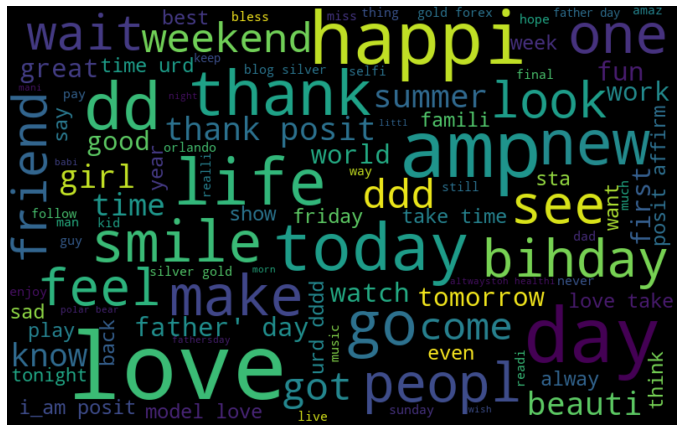

In [51]:
normal_words = ' '.join([word for word in data_frame['clean_tweet'][data_frame['label'] == 0]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 100).generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

Plotting wordcloud for negative words..

Normal words


(-0.5, 799.5, 499.5, -0.5)

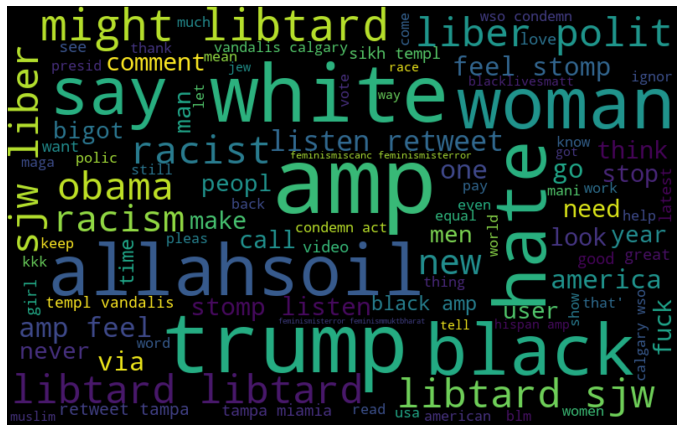

In [52]:
normal_words = ' '.join([word for word in data_frame['clean_tweet'][data_frame['label'] == 1]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 100).generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')

In [53]:
#Collecting positive hashtags

hash_positive = []
hash_negative = []

In [54]:
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

In [55]:
hash_positive = hashtag_extract(data_frame['clean_tweet'][data_frame['label'] == 0])

# extracting hashtags from racist/sexist tweets
hash_negative = hashtag_extract(data_frame['clean_tweet'][data_frame['label'] == 1])

# Converting a multidimensional list to a 1-D list
hash_positive = sum(hash_positive,[])
hash_negative = sum(hash_negative,[])

In [56]:

q = Counter(hash_positive)
q = dict(q.most_common())

In [57]:
l_positive_count = list(q.values())

In [58]:
l_positive_count[0:4]

[1579, 905, 636, 558]

In [59]:
r = Counter(hash_negative)
r = dict(r.most_common())

In [60]:
l_negative_count = list(r.values())

In [61]:
l_negative_count[0:4]

[133, 94, 92, 79]

In [62]:
l_positive_values = list(q.keys())

In [63]:
l_positive_values[0:4]

['love', 'posit', 'smile', 'healthi']

In [64]:
l_negative_values = list(r.keys())

In [65]:
l_negative_values[0:4]

['trump', 'polit', 'allahsoil', 'liber']

Creating a dataframe to represent top 20 positive and negative hash words

In [66]:

l1 = pd.DataFrame(l_positive_values[0:20],columns = ['Positive_Words'])
l2 = pd.DataFrame(l_positive_count[0:20],columns = ['Positive_Count'])
l3 = pd.DataFrame(l_negative_values[0:20],columns = ['Negative_Words'])
l4 = pd.DataFrame(l_negative_count[0:20],columns = ['Negative_Count'])
z = pd.concat([l1,l2,l3,l4],axis = 1)
z

,Positive_Words,Positive_Count,Negative_Words,Negative_Count
0,love,1579,trump,133
1,posit,905,polit,94
2,smile,636,allahsoil,92
3,healthi,558,liber,79
4,thank,526,libtard,77
5,fun,434,sjw,75
6,affirm,422,retweet,57
7,life,399,black,46
8,model,374,miamia,38
9,summer,361,hate,36


Animated plot for positive words with their frequency

In [67]:

fig = px.bar(z, x="Positive_Words", y="Positive_Count",animation_frame="Positive_Count",
            hover_name="Positive_Words")
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1200
fig.show()


Animated plot for negative words with their frequency

In [68]:

fig = px.bar(z, x="Negative_Words", y="Negative_Count",animation_frame="Negative_Count",
            hover_name="Negative_Words")
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 1200
fig.show()


Normal histogram of positive words

In [69]:

fig = px.bar(z, x="Positive_Words", y="Positive_Count",
            hover_name="Positive_Words",color = 'Positive_Count')
fig.show()

Normal histogram of negative words

In [70]:

fig = px.bar(z, x="Negative_Words", y="Negative_Count",
            hover_name="Negative_Words",color= 'Negative_Count')
fig.show()

In [71]:
data_frame.head()

,id,label,tweet,clean_tweet,Hash words
0,1,0,@user when a father is dysfunctional and is s...,father dysfunct selfish drag kid dysfunction. ...,#run
1,2,0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit can't use caus offer wheelc...,#lyft #disapointed #getthanked
2,3,0,bihday your majesty,bihday majesti,No hashtags
3,4,0,#model i love u take with u all the time in ...,#model love u take u time urd+-!!! dddd d|d|d|,#model
4,5,0,factsguide: society now #motivation,factsguide: societi #motiv,#motivation


In [72]:
data_frame.to_csv('dataframe.csv')

## 2. TF-IDF approach

In [73]:
#Techniques to convert the tweets into TF-IDF vectors
#Building various classifiers: -
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2,stop_words='english')
# TF-IDF feature matrix
X1 = tfidf_vectorizer.fit_transform(corpus).toarray()
Y1 = df.loc[:,'label'].values

In [74]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(data_frame['clean_tweet'], data_frame['label'], test_size = 0.3, random_state=0, shuffle = True, stratify=data_frame['label'])
vectorizer = TfidfVectorizer()
X1_train_vect = vectorizer.fit_transform(X1_train)
Y1 = df.loc[:,'label'].values

In [75]:
#Random Forest using pipelines
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier())])
rf.fit(X1_train, Y1_train)
y_pred = rf.predict(X1_test)
print(pd.crosstab(Y1_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(Y1_test, y_pred))

Predicted     0    1
Actual              
0          8888   28
1           340  333
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      8916
           1       0.92      0.49      0.64       673

    accuracy                           0.96      9589
   macro avg       0.94      0.75      0.81      9589
weighted avg       0.96      0.96      0.96      9589



In [76]:
print(rf.predict([""]))

[0]


In [77]:
 from sklearn import metrics

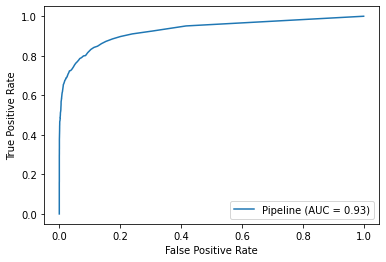

In [78]:
metrics.plot_roc_curve(rf, X1_test, Y1_test)
plt.show() 

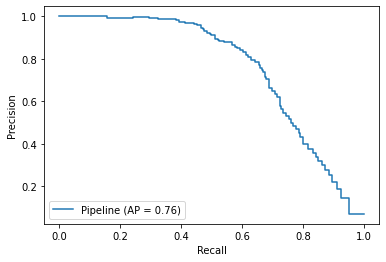

In [79]:
metrics.plot_precision_recall_curve(rf, X1_test, Y1_test)
plt.show() 

## 3. Autogluon approach

In [80]:
from autogluon import TabularPrediction as task

In [81]:
df

,id,label,tweet,clean_tweet,#
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...,#run
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause they...,#lyft #disapointed #getthanked
2,3,0,bihday your majesty,bihday your majesty,
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ur...,#model
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation,#motivation
...,...,...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...,"ate isz that youuu?ddddddddda$?i,",
31958,31959,0,to see nina turner on the airwaves trying to...,to see nina turner on the airwaves trying to w...,#shame #imwithher
31959,31960,0,listening to sad songs on a monday morning otw...,listening to sad songs on a monday morning otw...,
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,...","#sikh #temple vandalised in in #calgary, #wso ...","#sikh #temple #calgary, #wso"


In [82]:
df.to_csv('cleantweets_auto.csv')

In [83]:
df_clean_twt = df[['label','clean_tweet']].copy()

In [84]:
print(df_clean_twt.iloc[31960, 1])

#sikh #temple vandalised in in #calgary, #wso condemns act


In [85]:
df_clean_twt

,label,clean_tweet
0,0,when a father is dysfunctional and is so selfi...
1,0,thanks for #lyft credit i can't use cause they...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ur...
4,0,factsguide: society now #motivation
...,...,...
31957,0,"ate isz that youuu?ddddddddda$?i,"
31958,0,to see nina turner on the airwaves trying to w...
31959,0,listening to sad songs on a monday morning otw...
31960,1,"#sikh #temple vandalised in in #calgary, #wso ..."


In [86]:
# Read data
df_clean_twt.columns = ["Label","Text"]
print(df_clean_twt.shape)
df_clean_twt.head()

X = df[['clean_tweet']].copy()
y = df[['label']].copy()

(31962, 2)


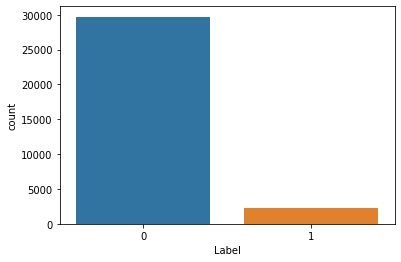

In [87]:
import seaborn as sns
sns.countplot(x='Label', data=df_clean_twt)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 42) 

In [89]:
X_test

,clean_tweet
17579,donnabrill - na: #slut #naughty #wet #hot #hor...
6194,hai everyone i want to say goodbye.. because i...
7295,is officially a working girl again!
22888,how did i get so lucky? #saycheese gamber comm...
23658,aww yeah it's all good bing bong bing bong
...,...
18586,tomorrow and her mama get to come visit me in ...
1066,oh.my.books its so beautiful! oh the feels! al...
29226,june 22 is a good friend's bihday celebration ...
5374,it's one week till spos day!


In [90]:
y_train.label.value_counts()

0    20804
1     1569
Name: label, dtype: int64

In [91]:
y_test.label.value_counts()

0    8916
1     673
Name: label, dtype: int64

In [92]:
from imblearn.over_sampling import RandomOverSampler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [93]:
ros = RandomOverSampler()

X_train, y_train = ros.fit_sample(X_train, y_train) 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [94]:
ros = RandomOverSampler()

X_test, y_test = ros.fit_sample(X_test, y_test) 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [95]:
X_train.shape, y_train.shape

((41608, 1), (41608,))

In [96]:
X_test.shape, y_test.shape

((17832, 1), (17832,))

In [97]:

#train data 
tweets = np.array(X_train)
label = np.array(y_train)
train_data = pd.DataFrame({'label': list(label), 'tweets': list(tweets)}, columns=['label', 'tweets'])

In [98]:
#test data 
tweets = np.array(X_test)
label = np.array(y_test)
test_data = pd.DataFrame({'label': list(label), 'tweets': list(tweets)}, columns=['label', 'tweets'])

In [99]:
train_data

,label,tweets
0,0,[happy bihday to my brother man. needed this m...
1,0,[lang to sta the week right :) #happiness #smile]
2,0,"[note it meditate on it work on it ,but most i..."
3,0,"[listening to you this wet mon, ahead of #leed..."
4,1,[agreed.. the same is true for and .. they are...
...,...,...
41603,1,[#preorder your copy of hot new #dystopian swi...
41604,1,[#newyear! new #prez. new #destruction. new #c...
41605,1,"[#bigot carl paladino, ally, wishes obama dead..."
41606,1,[#history will not be kind to those who enable...


In [100]:
test_data

,label,tweets
0,0,[donnabrill - na: #slut #naughty #wet #hot #ho...
1,0,[hai everyone i want to say goodbye.. because ...
2,0,[is officially a working girl again!]
3,0,[how did i get so lucky? #saycheese gamber com...
4,0,[aww yeah it's all good bing bong bing bong]
...,...,...
17827,1,[most likely the us is deploying bc we're and ...
17828,1,[when you're blocked by a troll because you pr...
17829,1,[will the alt-right promote a new kind of gene...
17830,1,[racism at home and anti- advice for others: w...


In [101]:
train_data['tweets'] = train_data['tweets'].apply(', '.join)

In [102]:
test_data['tweets'] = test_data['tweets'].apply(', '.join)

In [103]:
%%time
#TRAIN THE MODEL

predictor = task.fit(train_data=train_data, label='label')
performance = predictor.evaluate(train_data)

No output_directory specified. Models will be saved in: AutogluonModels/ag-20210127_012500/
Beginning AutoGluon training ...
AutoGluon will save models to AutogluonModels/ag-20210127_012500/
AutoGluon Version:  0.0.15
Train Data Rows:    41608
Train Data Columns: 1
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9025.5 MB
	Train Data (Original)  Memory Usage: 5.6 MB (0.1% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dt

Predictive performance on given dataset: accuracy = 0.9999759661603538
CPU times: user 27min 8s, sys: 15.3 s, total: 27min 23s
Wall time: 16min 10s


In [104]:
performance = predictor.evaluate(test_data)

Predictive performance on given dataset: accuracy = 0.5994279946164199


In [105]:
# TEST OUT-OF-SAMPLE

y_test = test_data['label']
test_data_nolabel = test_data.drop(labels=['label'],axis=1)
y_pred = predictor.predict(test_data_nolabel)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred= y_pred, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.5994279946164199
Evaluations on test data:
{
    "accuracy": 0.5994279946164199,
    "accuracy_score": 0.5994279946164199,
    "balanced_accuracy_score": 0.5994279946164199,
    "matthews_corrcoef": 0.33227305060846807,
    "f1_score": 0.5994279946164199
}
Detailed (per-class) classification report:
{
    "0": {
        "precision": 0.5552026900803287,
        "recall": 1.0,
        "f1-score": 0.7139939939939939,
        "support": 8916
    },
    "1": {
        "precision": 1.0,
        "recall": 0.19885598923283984,
        "f1-score": 0.3317429132753298,
        "support": 8916
    },
    "accuracy": 0.5994279946164199,
    "macro avg": {
        "precision": 0.7776013450401644,
        "recall": 0.5994279946164199,
        "f1-score": 0.5228684536346618,
        "support": 17832
    },
    "weighted avg": {
        "precision": 0.7776013450401643,
        "recall": 0.5994279946164199,
        "f1-score": 0.5228684536346618,
        "support": 1

In [106]:
leaderboard = predictor.leaderboard(test_data)

                        model  score_test  score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        LightGBMClassifierXT    0.794471     0.9804        0.706951       0.105841    4.828150                 0.706951                0.105841           4.828150            0       True          6
1    ExtraTreesClassifierEntr    0.704520     0.9976        2.172650       0.314595   72.686589                 2.172650                0.314595          72.686589            0       True          4
2  RandomForestClassifierEntr    0.703174     0.9960        1.435663       0.314548   45.942969                 1.435663                0.314548          45.942969            0       True          2
3    ExtraTreesClassifierGini    0.694650     0.9980        2.091384       0.315098   70.815474                 2.091384                0.315098          70.815474            0       True          3
4  Ra

In [107]:

data = {'tweets':['He is the kind of anti-white' , 'that will whine about ',' anti-White racism ' , 'instead of just calling them ', 'anti-White ','love','smile']} 
  
# Create DataFrame 
sample_test_df = pd.DataFrame(data) 
sample_test_df

,tweets
0,He is the kind of anti-white
1,that will whine about
2,anti-White racism
3,instead of just calling them
4,anti-White
5,love
6,smile


In [108]:
predictor.predict(sample_test_df)


array([0, 0, 0, 0, 0, 0, 0])

In [109]:
import pickle

In [110]:
filename = 'weighted_ensemble_k0_l1.pkl'
pickle.dump(predictor, open(filename, 'wb'))

## 5.  Language Modelling using BERT 

In [17]:
import json
from sklearn import feature_extraction, feature_selection, metrics
from sklearn import model_selection, naive_bayes, pipeline, manifold, preprocessing
import gensim
import gensim.downloader as gensim_api
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
import transformers

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [37]:
df_clean_twt = pd.read_csv('/content/cleantweets_auto.csv')

In [38]:
df_clean_twt = df_clean_twt[['label','clean_tweet']].copy()

In [39]:
# Read data
df_clean_twt.columns = ["Label","Text"]
print(df_clean_twt.shape)
df_clean_twt.head()


(31962, 2)


,Label,Text
0,0,when a father is dysfunctional and is so selfi...
1,0,thanks for #lyft credit i can't use cause they...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ur...
4,0,factsguide: society now #motivation


Get pretrained model

In [40]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [41]:
# Reduced Dataset 

df_clean_twt_small = df_clean_twt[:1000].copy()

In [42]:
df_clean_twt_small

,Label,Text
0,0,when a father is dysfunctional and is so selfi...
1,0,thanks for #lyft credit i can't use cause they...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ur...
4,0,factsguide: society now #motivation
...,...,...
995,0,are you really or just pretending to be? #trut...
996,0,i finally found a way how to delete old tweets...
997,0,what a #view #oregon #poland #usa #unitedstate...
998,0,"have you put in your #vote yet? if you havent,..."


In [44]:
df_clean_twt_small.Label.value_counts()

0    925
1     75
Name: Label, dtype: int64

In [ ]:
# Get tokenized version
tokenized = df_clean_twt["Text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
print(tokenized.shape)
tokenized[0]

Construct Token ID and Mask

In [120]:
# Add padding and set max len to the longest entry in the dataset
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
print(np.array(padded).shape)
padded[:3]

(31962, 140)


array([[  101,  2043,  1037,  2269,  2003, 28466,  2389,  1998,  2003,
         2061, 14337,  2002,  8011,  2015,  2010,  4268,  2046,  2010,
        28466,  1012,  1001,  2448,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [121]:
# Add a mask to let BERT know where the real tokens are and not the padding
# Essentially we can use zero for the padding mask so those tokens do not compute
attention_mask = np.where(padded != 0, 1, 0)
print(attention_mask.shape)
attention_mask[:3]

(31962, 140)


array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,

Run Token ID and Attention Mask

In [3]:
import torch

In [ ]:
%%time
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)  #embeddings

In [ ]:

# Embeddings from BERT
print(len(last_hidden_states[0][:,0,:]))
last_hidden_states[0][:,0,:]

Testing DistilBERT

In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig , DistilBertModel
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
import gc
gc.collect()        


507

In [31]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig , DistilBertModel
import transformers as ppb

In [32]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
df = pd.read_csv('/content/train_E6oV3lV.csv', sep="\t",usecols = ['Phrase','Sentiment'])

In [ ]:
df = df.rename(columns={'Phrase': 0 , 'Sentiment' : 1})
df.head()

In [ ]:
## Subset 
batch_1 = df[:2000]
batch_1[1].value_counts()

In [ ]:
batch_1 = df_clean_twt[:1000]


In [ ]:
batch_1["Label"].value_counts()

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

## Want BERT instead of distilBERT? Uncomment the following line:
#model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [ ]:
### Tokenization¶
tokenized = batch_1["Text"].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
## Padding
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
## Masking
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

In [ ]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
#We'll save those in the features variable, as they'll serve as the features to our logitics regression model.
features = last_hidden_states[0][:,0,:].numpy()

#lables - Target 
labels = batch_1["Label"]

In [ ]:
labels

In [ ]:
# Input to the Logistic Regression
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)


In [ ]:
lr_clf = LogisticRegression(multi_class = 'ovr', C=1, solver='sag')
lr_clf.fit(train_features, train_labels)

In [ ]:
# Model Evaluation 
lr_clf.score(test_features, test_labels)